# Bank of England, ONS, Halifax, Nationwide, Rightmove data

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import date
from matplotlib.ticker import FuncFormatter
import statsmodels.api as sm
from scipy.stats import linregress
import requests
import io
import os
from pathlib import Path
import numpy as np

DATA_DIR = "data"
PLOT_DIR = "plots"

In [2]:
def get_boe_data(
    name: str,
    codes: str,
    start_date: str,
    end_date: str = "",
) -> pd.DataFrame:
    """Return DataFrame with requested BoE data."""

    today = date.today()
    filename = name + "_" + today.strftime("%Y%m%d") + ".pkl"
    filename = os.path.join(DATA_DIR, filename)

    if Path(filename).is_file():  # already fetched
        return pd.read_pickle(filename)

    url = "http://www.bankofengland.co.uk/boeapps/iadb/fromshowcolumns.asp?csv.x=yes"

    params = {
        "Datefrom": start_date,
        "Dateto": end_date if end_date != "" else today.strftime("%d/%b/%Y"),
        "SeriesCodes": codes,
        "CSVF": "TN",
        "UsingCodes": "Y",
        "VPD": "Y",
        "VFD": "N",
    }

    headers = {
        "User-Agent": "Mozilla/5.0 (X11; Linux x86_64) "
        "AppleWebKit/537.36 (KHTML, like Gecko) "
        "Chrome/54.0.2840.90 "
        "Safari/537.36"
    }

    response = requests.get(url, params=params, headers=headers)
    print(response.status_code)
    # print(response.url)
    # print(response.content)
    df_boe = pd.read_csv(io.BytesIO(response.content))
    df_boe["DATE"] = pd.to_datetime(df_boe["DATE"], format="%d %b %Y")
    df_boe.to_pickle(filename)
    return df_boe

In [3]:
def get_ons_data(name: str = "cpih") -> pd.DataFrame:
    """Return DataFrame with requested ONS data.

    Currently hard coded for CPIH.
    """

    today = date.today()
    filename = name + "_" + today.strftime("%Y%m%d") + ".pkl"
    filename = os.path.join(DATA_DIR, filename)

    if Path(filename).is_file():  # already fetched
        return pd.read_pickle(filename)

    url = "https://api.beta.ons.gov.uk/v1/datasets/cpih01/editions/time-series/versions/53/observations"
    params = {
        "time": "*",
        "geography": "K02000001",
        "aggregate": "CP00",
    }

    response = requests.get(url, params=params)
    print("Status Code:", response.status_code)
    # print("URL Requested:", response.url)

    results = response.json()
    # print(results)
    summary = []
    for observation in results.get("observations"):
        ident = observation.get("dimensions").get("Time").get("id")
        summary.append({"id": ident, "observation": observation.get("observation")})
    df_ons = pd.DataFrame(summary)

    # hard set for CPIH
    df_ons.columns = ["Date", "CPIH"]
    df_ons["Date"] = pd.to_datetime(df_ons["Date"], format="%b-%y")
    df_ons["CPIH"] = df_ons["CPIH"].astype("float64")
    df_ons.to_pickle(filename)
    return df_ons

In [4]:
def pound_formatter(x, pos) -> str:
    """Return a £ formatted string."""
    if x >= 1_000_000_000_000:  # trillions
        return f"£{x / 1_000_000_000_000:.2f} tn"
    elif x >= 1_000_000_000:  # billions
        return f"£{x / 1_000_000_000:.1f} bn"
    elif x >= 1_000_000:  # millions
        return f"£{x / 1_000_000:.1f} mn"
    elif x >= 1_000:  # thousands
        return f"£{x / 1_000:.1f}k"
    else:
        return f"£{x:,.0f}"

## Rightmove HPI

In [5]:
def get_rightmove_data() -> pd.DataFrame:
    """Return DataFrame with Rightmove house prices."""
    filename = "rightmove_hpi.csv"
    filename = os.path.join(DATA_DIR, filename)
    return pd.read_csv(filename)


df_rm = get_rightmove_data()
df_rm.columns = ["Date", "Price"]
df_rm["Date"] = pd.to_datetime(df_rm["Date"], format="%b %y")
df_rm = df_rm.sort_values(by="Date")
df_rm["Month_Year"] = df_rm["Date"].dt.strftime("%b %y")
last_date = df_rm["Date"].max().strftime("%d %b %y")
print(last_date)

01 Dec 24


## Nationwide HPI

In [6]:
def get_nationwide_data() -> pd.DataFrame:
    """Return DataFrame with Nationwide house prices."""

    today = date.today()
    filename = "nationwide_" + today.strftime("%Y%m%d") + ".xlsx"
    filename = os.path.join(DATA_DIR, filename)

    if Path(filename).is_file():  # already fetched
        return pd.read_excel(filename)

    url = "https://www.nationwidehousepriceindex.co.uk/download/uk-monthly-index"
    response = requests.get(url)
    with open(filename, "wb") as file:
        file.write(response.content)
    return pd.read_excel(filename)


df_nw = get_nationwide_data()
df_nw.columns = ["Date", "Price"] + df_nw.columns[2:].tolist()
df_nw = df_nw.sort_values(by="Date")
df_nw["Month_Year"] = df_nw["Date"].dt.strftime("%b %y")
df_nw = df_nw[df_nw["Date"] >= "2000-01-01"]
last_date = df_nw["Date"].max().strftime("%d %b %y")
print(last_date)

01 Nov 24


/home/unknown/Documents/houses/econ/venv/lib/python3.12/site-packages/openpyxl/reader/workbook.py:118: UserWarning: Print area cannot be set to Defined name: Monthly!$A:$F.
  warn(f"Print area cannot be set to Defined name: {defn.value}.")


## Halifax HPI

In [7]:
def get_halifax_data() -> pd.DataFrame:
    """Return DataFrame with Halifax house prices."""
    filename = "halifax_hpi.csv"
    filename = os.path.join(DATA_DIR, filename)
    return pd.read_csv(filename)


df_hal = get_halifax_data()
df_hal.columns = ["Date", "Price"]
df_hal["Date"] = pd.to_datetime(df_hal["Date"], format="%b %y")
df_hal = df_hal.sort_values(by="Date")
df_hal["Month_Year"] = df_hal["Date"].dt.strftime("%b %y")
df_hal = df_hal[df_hal["Date"] >= "2000-01-01"]
last_date = df_hal["Date"].max().strftime("%d %b %y")
print(last_date)

01 Nov 24


## Zoopla HPI

Note that prior to 2023-06 the numbers are interpolated from the graph https://reports.hometrack.com/uk/insight/uk-house-price-index/

In [8]:
def get_zoopla_data() -> pd.DataFrame:
    """Return DataFrame with Zoopla house prices."""
    filename = "zoopla_hpi.csv"
    filename = os.path.join(DATA_DIR, filename)
    return pd.read_csv(filename)


df_zoo = get_zoopla_data()
df_zoo.columns = ["Date", "Price"]
df_zoo["Date"] = pd.to_datetime(df_zoo["Date"], format="%Y-%m")
df_zoo = df_zoo.sort_values(by="Date")
df_zoo["Month_Year"] = df_zoo["Date"].dt.strftime("%b %y")
df_zoo = df_zoo[df_zoo["Date"] >= "2000-01-01"]
last_date = df_zoo["Date"].max().strftime("%d %b %y")
print(last_date)

01 Oct 24


## ONS HPI

In [9]:
def get_ons_hpi(sheet: int) -> pd.DataFrame:
    """Return DataFrame with ONS house price index.

    Currently hard set to December 2024. Probably not the best dataset.
    """

    today = date.today()
    filename = "ons_hpi_" + today.strftime("%Y%m%d") + ".xlsx"
    filename = os.path.join(DATA_DIR, filename)

    if Path(filename).is_file():  # already fetched
        return pd.read_excel(filename, sheet_name=sheet)

    url = "https://www.ons.gov.uk/file?uri=/economy/inflationandpriceindices/datasets/ukhousepriceindexmonthlypricestatistics/18december2024/ukhousepriceindexmonthlypricestatistics.xlsx"
    response = requests.get(url)
    with open(filename, "wb") as file:
        file.write(response.content)
    return pd.read_excel(filename, sheet_name=sheet)

In [10]:
df_ons_hpi = get_ons_hpi(sheet=4)
df_ons_hpi = df_ons_hpi.iloc[2:]  # drop first two rows
df_ons_hpi = df_ons_hpi.iloc[:, :2]  # drop all but first two cols
df_ons_hpi.columns = ["Date", "Price"]
# Clean up dates and convert to datetime
df_ons_hpi["Date"] = (
    df_ons_hpi["Date"].str.replace(r"\s*\[.*?\]", "", regex=True).str.strip()
)
df_ons_hpi["Date"] = df_ons_hpi["Date"].apply(
    lambda x: x.replace("June", "Jun").replace("July", "Jul")
)
# convert to date object
df_ons_hpi["Date"] = pd.to_datetime(df_ons_hpi["Date"], format="%b %Y")
# add month year col
df_ons_hpi["Month_Year"] = df_ons_hpi["Date"].dt.strftime("%b %y")

In [11]:
df_ftb = get_ons_hpi(sheet=6)
df_ftb = df_ftb.iloc[4:]  # drop first five rows
df_ftb = df_ftb.drop(df_ftb.columns[[3, 4]], axis=1)
df_ftb.columns = ["Date", "FTB_Price", "FOO_Price", "FTB_Change", "FOO_Change"]
# Clean up dates and convert to datetime
df_ftb["Date"] = df_ftb["Date"].str.replace(r"\s*\[.*?\]", "", regex=True).str.strip()
df_ftb["Date"] = df_ftb["Date"].apply(
    lambda x: x.replace("June", "Jun").replace("July", "Jul")
)
# convert to date object
df_ftb["Date"] = pd.to_datetime(df_ftb["Date"], format="%b %Y")
# add month year col
df_ftb["Month_Year"] = df_ftb["Date"].dt.strftime("%b %y")
# clean up
df_ftb = df_ftb.replace("[x]", np.nan)
df_ftb = df_ftb[df_ftb["Date"] >= "2023-01-01"]
last_date = df_ftb["Date"].max().strftime("%d %b %y")
print(last_date)

01 Oct 24


/tmp/ipykernel_45292/2806823837.py:15: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_ftb = df_ftb.replace("[x]", np.nan)


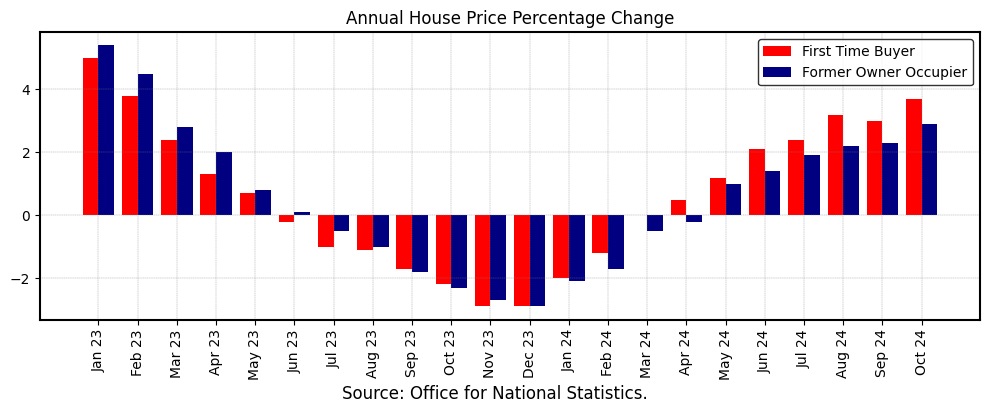

In [12]:
fig, ax = plt.subplots(figsize=(10, 4))
ax.set_facecolor("white")

categories = df_ftb["Month_Year"]
bar_width = 0.4
x = np.arange(len(categories))
x2 = x + bar_width

ax.bar(x, df_ftb["FTB_Change"], width=bar_width, label="First Time Buyer", color="red")
ax.bar(
    x2,
    df_ftb["FOO_Change"],
    width=bar_width,
    label="Former Owner Occupier",
    color="navy",
)
ax.grid(True, color="grey", linestyle="--", linewidth=0.25)

ax.set_title("Annual House Price Percentage Change")
xticks = df_ftb["Month_Year"][::1]  # every nth date

plt.xticks(x + bar_width / 2, categories, rotation=90)

for spine in ax.spines.values():
    spine.set_edgecolor("black")
    spine.set_linewidth(1.5)
fig.text(
    0.5,
    -0.01,
    "Source: Office for National Statistics.",
    ha="center",
    fontsize=12,
    color="black",
)

plt.legend(facecolor="white", edgecolor="black", fontsize=10)
plt.tight_layout()

filename = os.path.join(PLOT_DIR, "ftb_foo_change.png")
plt.savefig(filename, dpi=300, bbox_inches="tight")

## Mortgages

In [13]:
df_mort = get_boe_data("mortgages", "LPMB3C2,LPMVTVU", "01/Jan/2000")
df_mort.columns = ["Date", "Total", "Number"]
df_mort["Price"] = df_mort["Total"] / df_mort["Number"] * 1000000
df_mort = df_mort.sort_values(by="Date")
df_mort["Month_Year"] = df_mort["Date"].dt.strftime("%b %y")
last_date = df_mort["Date"].max().strftime("%d %b %y")

## Plot HPI & Mortgage Borrowing

In [14]:
def plot_hpi(start_date: str, data: dict[str, pd.DataFrame], xfreq: int) -> None:
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.set_facecolor("white")

    max_df = None  # varying length so find the longest month/year df
    for label, df in data.items():
        df_filtered = df[df["Date"] >= start_date]
        ax.plot(df_filtered["Month_Year"], df_filtered["Price"], label=label)
        if max_df is None or len(max_df) < len(df_filtered):
            max_df = df_filtered

    ax.set_title(
        "House Price Indices & Bank of England Value of Mortgages Approved",
        fontsize=14,
    )
    formatter = FuncFormatter(lambda x, pos: f"£{x:,.0f}")
    plt.gca().yaxis.set_major_formatter(formatter)
    ax.grid(True, color="grey", linestyle="--", linewidth=0.25)
    xticks = max_df["Month_Year"][::xfreq]  # every nth date
    plt.xticks(xticks, rotation=90)
    for spine in ax.spines.values():
        spine.set_edgecolor("black")
        spine.set_linewidth(1.5)

    last_date = max_df.iloc[-1]["Date"].strftime("%b %y")
    fig.text(
        0.5,
        -0.01,
        f"Source: Bank of England, ONS, Halifax, Nationwide, Rightmove, & Zoopla. Last date: {last_date}",
        ha="center",
        fontsize=12,
        color="black",
    )
    plt.legend(facecolor="white", edgecolor="black", fontsize=10)
    plt.tight_layout()

    filename = os.path.join(PLOT_DIR, f"house_prices_{start_date}.png")
    plt.savefig(filename, dpi=300, bbox_inches="tight")

In [15]:
data: dict = {
    "BoE Value of Mortgages Approved for Each Approval": df_mort,
    "Nationwide House Price Index": df_nw,
    "Halifax House Price Index": df_hal,
    "Rightmove House Price Index": df_rm,
    "Zoopla House Price Index": df_zoo,
    "ONS House Price Index": df_ons_hpi,
}

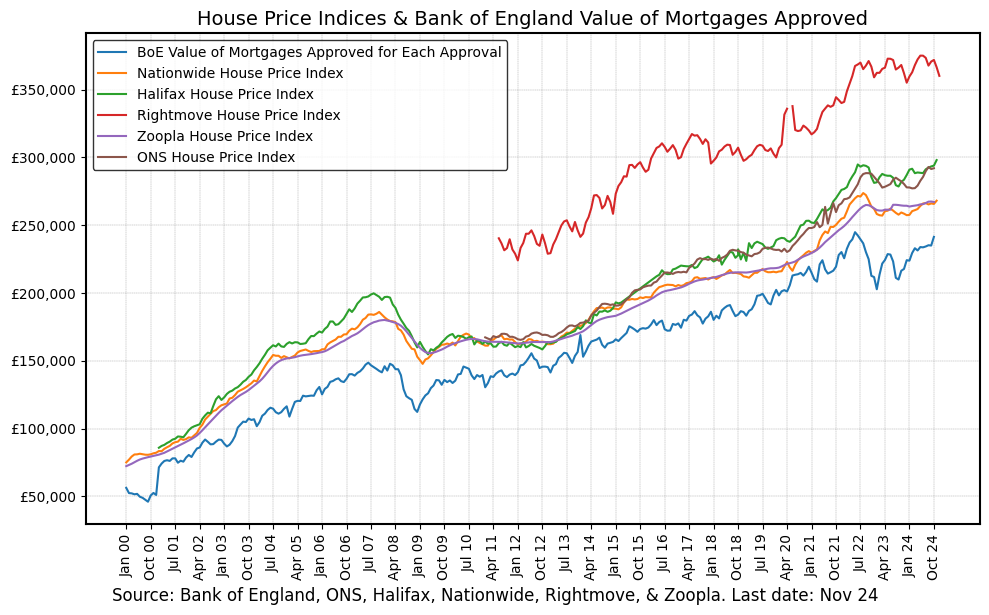

In [16]:
plot_hpi(start_date="2000-01-01", data=data, xfreq=9)

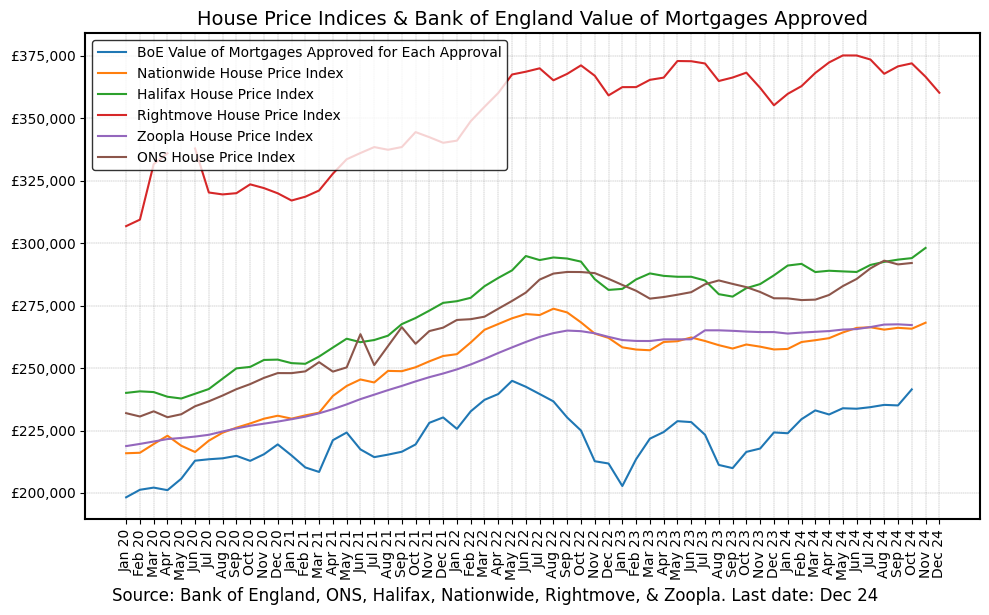

In [17]:
plot_hpi(start_date="2020-01-01", data=data, xfreq=1)

## ONS HPI Revisions

In [18]:
def get_ons_revision_data() -> pd.DataFrame:
    """Return DataFrame with ONS revisions to house prices."""
    filename = "ons_estimates.csv"
    filename = os.path.join(DATA_DIR, filename)
    return pd.read_csv(filename)


df_rev = get_ons_revision_data()
df_rev.columns = ["Date", "New", "Orig"]
df_rev["Date"] = pd.to_datetime(df_rev["Date"], format="%b %Y")
df_rev = df_rev.sort_values(by="Date")
df_rev["Month_Year"] = df_rev["Date"].dt.strftime("%b %y")
df_rev = df_rev[df_rev["Date"] >= "2022-01-01"]

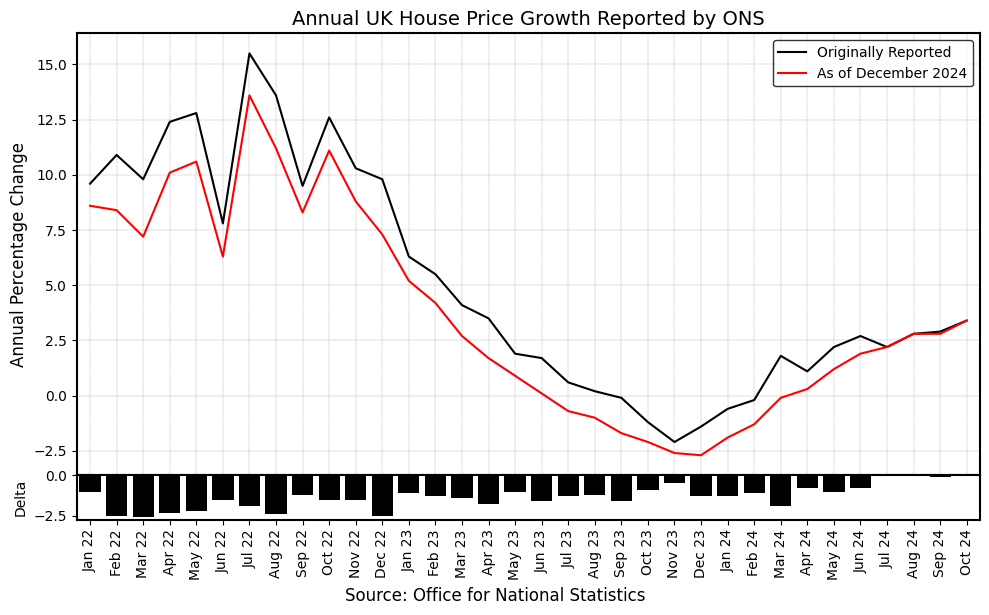

In [19]:
fig = plt.figure(figsize=(10, 6))
gs = fig.add_gridspec(2, 1, height_ratios=[10, 1], hspace=0)

ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1])

ax1.set_title("Annual UK House Price Growth Reported by ONS", fontsize=14)
ax1.plot(
    df_rev["Month_Year"], df_rev["Orig"], label="Originally Reported", color="black"
)
ax1.plot(df_rev["Month_Year"], df_rev["New"], label="As of December 2024", color="red")
ax1.set_ylabel("Annual Percentage Change", fontsize="12")
ax1.grid(True, color="grey", linestyle="--", linewidth=0.25)

ax1.set_xticks(range(len(df_rev["Month_Year"])))
ax1.set_xticklabels([])  # no labels for ax1
ax1.set_xlim(-0.5, len(df_rev["Month_Year"]) - 0.5)  # align x-ticks

ax1.legend(facecolor="white", edgecolor="black", fontsize=10)

for spine in ax1.spines.values():
    spine.set_edgecolor("black")
    spine.set_linewidth(1.5)

difference = df_rev["New"] - df_rev["Orig"]
ax2.bar(df_rev["Month_Year"], difference, color="black")
ax2.set_ylabel("Delta")

ax2.set_xticks(range(len(df_rev["Month_Year"])))
ax2.set_xticklabels(df_rev["Month_Year"], rotation=90, ha="center")
ax2.set_xlim(-0.5, len(df_rev["Month_Year"]) - 0.5)  # align x-ticks

for spine in ax2.spines.values():
    spine.set_edgecolor("black")
    spine.set_linewidth(1.5)

fig.text(
    0.5,
    -0.01,
    "Source: Office for National Statistics",
    ha="center",
    fontsize=12,
    color="black",
)

plt.tight_layout()

filename = os.path.join(PLOT_DIR, "ons_revisions.png")
plt.savefig(filename, dpi=300, bbox_inches="tight")

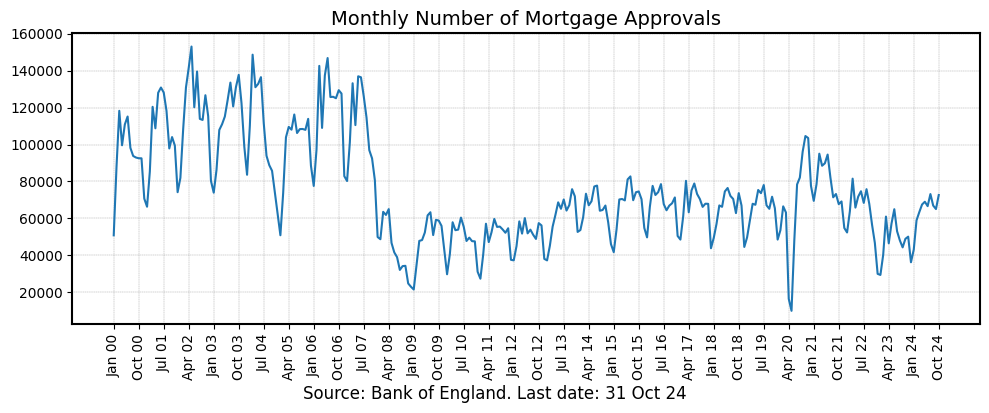

In [20]:
fig, ax = plt.subplots(figsize=(10, 4))
ax.set_facecolor("white")
ax.plot(df_mort["Month_Year"], df_mort["Number"])
ax.set_title("Monthly Number of Mortgage Approvals", fontsize=14)
ax.grid(True, color="grey", linestyle="--", linewidth=0.25)
xticks = df_mort["Month_Year"][::9]  # every nth date
plt.xticks(xticks, rotation=90)
for spine in ax.spines.values():
    spine.set_edgecolor("black")
    spine.set_linewidth(1.5)
fig.text(
    0.5,
    -0.01,
    f"Source: Bank of England. Last date: {last_date}",
    ha="center",
    fontsize=12,
    color="black",
)
plt.tight_layout()

filename = os.path.join(PLOT_DIR, "mortgages_number.png")
plt.savefig(filename, dpi=300, bbox_inches="tight")

## Total Secured Lending to Individuals

In [21]:
df_lend = get_boe_data("lending", "LPMVTXH", "01/Jan/2015")
df_lend.columns = ["Date", "Total"]
df_lend["Total"] = df_lend["Total"] * 1000000
df_lend = df_lend.sort_values(by="Date")
df_lend["Month_Year"] = df_lend["Date"].dt.strftime("%b %y")
last_date = df_lend["Date"].max().strftime("%d %b %y")

In [22]:
# Convert dates to numeric format for regression (e.g., as days since the first date)
df_lend["days"] = (df_lend["Date"] - df_lend["Date"].min()).dt.days

# Split the data based on the date
mid_date = "2020-01-31"  # pre-covid
end_date = "2022-11-30"  #
new_date = "2024-05-31"  # return to normal
df_normal = df_lend[df_lend["Date"] <= mid_date]
df_covid = df_lend[(df_lend["Date"] >= mid_date) & (df_lend["Date"] <= end_date)]
df_flat = df_lend[(df_lend["Date"] >= end_date) & (df_lend["Date"] <= new_date)]
df_new = df_lend[df_lend["Date"] >= new_date]

# fit linear regression on pre-covid
slope, intercept, rvalue, _, _ = linregress(df_normal["days"], df_normal["Total"])
precovid_r_squared = rvalue**2
df_lend["pre-covid"] = intercept + slope * df_lend["days"]

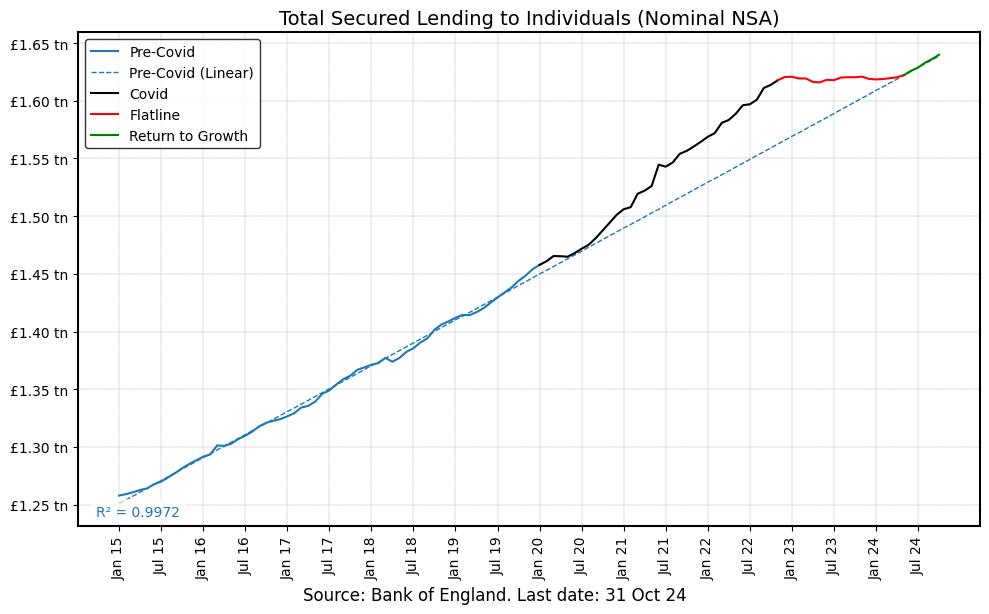

In [23]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.set_facecolor("white")

# pre-covid
(line1,) = ax.plot(df_normal["Month_Year"], df_normal["Total"], label="Pre-Covid")
color = line1.get_color()

ax.plot(
    df_lend["Month_Year"],
    df_lend["pre-covid"],
    label="Pre-Covid (Linear)",
    color=color,
    linestyle="--",
    linewidth=1,
)

# covid
ax.plot(df_covid["Month_Year"], df_covid["Total"], color="black", label="Covid")

# Flat
ax.plot(df_flat["Month_Year"], df_flat["Total"], color="red", label="Flatline")

# return to normal
ax.plot(df_new["Month_Year"], df_new["Total"], color="green", label="Return to Growth")

ax.set_title("Total Secured Lending to Individuals (Nominal NSA)", fontsize=14)

formatter = FuncFormatter(pound_formatter)
plt.gca().yaxis.set_major_formatter(formatter)
ax.grid(True, color="grey", linestyle="--", linewidth=0.25)

xticks = df_lend["Month_Year"][::6]  # every nth date
plt.xticks(xticks, rotation=90)

for spine in ax.spines.values():
    spine.set_edgecolor("black")
    spine.set_linewidth(1.5)

fig.text(
    0.5,
    -0.01,
    f"Source: Bank of England. Last date: {last_date}",
    ha="center",
    fontsize=12,
    color="black",
)

# Add Pre-covid R-squared as a note in the bottom-left corner
plt.text(
    0.02,
    0.02,  # Position: from the bottom-left
    f"R² = {precovid_r_squared:.4f}",
    transform=plt.gca().transAxes,  # (0,0 is bottom-left)
    fontsize=10,
    color=color,
    bbox=dict(facecolor="white", alpha=0.7, edgecolor="none"),
)

plt.legend(facecolor="white", edgecolor="black", fontsize=10)
plt.tight_layout()

filename = os.path.join(PLOT_DIR, "lending.png")
plt.savefig(filename, dpi=300, bbox_inches="tight")

## Nominal Savings

In [24]:
df_nsav = get_boe_data(
    "savings", "LPMB8S4,LPMVYWO,LPMZOD3,LPMZOD4,LPMZOD5", "01/Jan/2011"
)
names = ["ISA", "Cash", "No_Interest", "Interest", "Time"]
df_nsav.columns = ["Date"] + names
df_nsav["Total"] = df_nsav[names].sum(axis=1) * 1000000
df_nsav = df_nsav.sort_values(by="Date")
df_nsav["Month_Year"] = df_nsav["Date"].dt.strftime("%b %y")
last_date = df_nsav["Date"].max().strftime("%d %b %y")

In [25]:
# Add pre-covid linear regression
start_date = "2011-01-01"
end_date = "2020-02-29"

# Filter data for the regression fit
fit_data = df_nsav[(df_nsav["Date"] >= start_date) & (df_nsav["Date"] <= end_date)]

# Convert dates to numeric format for regression (e.g., as days since the first date)
df_nsav["days"] = (df_nsav["Date"] - df_nsav["Date"].min()).dt.days
fit_data = df_nsav[
    (df_nsav["Date"] >= start_date) & (df_nsav["Date"] <= end_date)
].copy()

# Fit linear regression
slope, intercept, rvalue, _, _ = linregress(fit_data["days"], fit_data["Total"])

# Calculate R-squared
precovid_r_squared = rvalue**2

# Project regression line over the full date range
df_nsav["pre-covid"] = intercept + slope * df_nsav["days"]

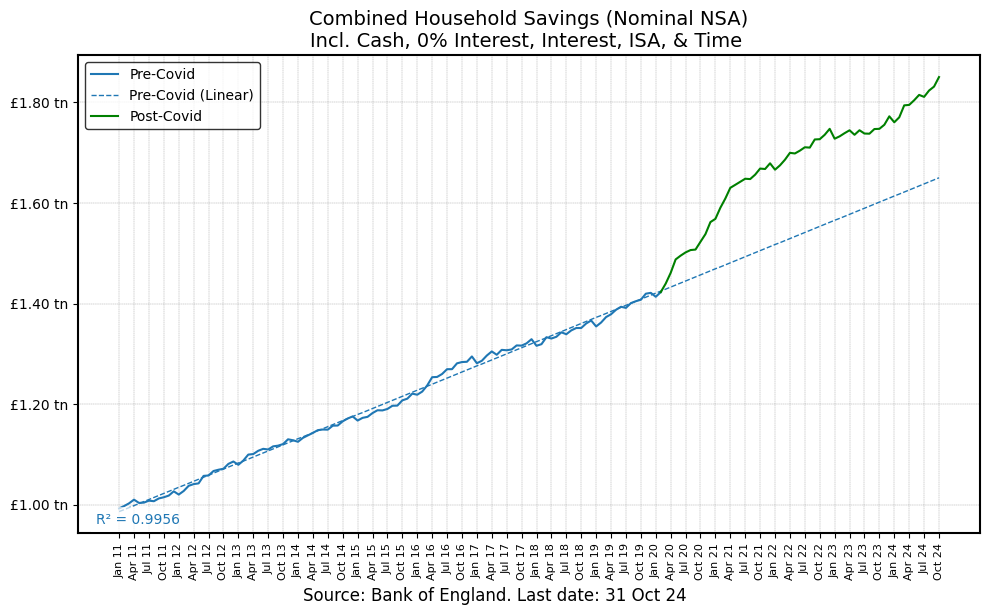

In [26]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.set_facecolor("white")

# Split the data into two parts based on the dates
df_nsav_precovid = df_nsav[df_nsav["Date"] <= end_date]
df_nsav_postcovid = df_nsav[df_nsav["Date"] >= end_date]

# Pre-covid
(line1,) = ax.plot(
    df_nsav_precovid["Month_Year"], df_nsav_precovid["Total"], label="Pre-Covid"
)
color = line1.get_color()

ax.plot(
    df_nsav["Month_Year"],
    df_nsav["pre-covid"],
    label="Pre-Covid (Linear)",
    color=color,
    linestyle="--",
    linewidth=1,
)

# Post-covid
ax.plot(
    df_nsav_postcovid["Month_Year"],
    df_nsav_postcovid["Total"],
    color="green",
    label="Post-Covid",
)

ax.set_title(
    "Combined Household Savings (Nominal NSA)\nIncl. Cash, 0% Interest, Interest, ISA, & Time ",
    fontsize=14,
)

formatter = FuncFormatter(pound_formatter)
plt.gca().yaxis.set_major_formatter(formatter)
ax.grid(True, color="grey", linestyle="--", linewidth=0.25)

xticks = df_nsav["Month_Year"][::3]  # every nth date
plt.xticks(xticks, rotation=90)
plt.tick_params(axis="x", labelsize=8)

# Set the spines (borders) to black
for spine in ax.spines.values():
    spine.set_edgecolor("black")
    spine.set_linewidth(1.5)

fig.text(
    0.5,
    -0.01,
    f"Source: Bank of England. Last date: {last_date}",
    ha="center",
    fontsize=12,
    color="black",
)

# Add R-squared as a note in the bottom-left corner
plt.text(
    0.02,
    0.02,  # Position: 2% from the bottom-left
    f"R² = {precovid_r_squared:.4f}",
    transform=plt.gca().transAxes,  # (0,0 is bottom-left)
    fontsize=10,
    color=color,
    bbox=dict(facecolor="white", alpha=0.7, edgecolor="none"),
)

plt.legend(facecolor="white", edgecolor="black", fontsize=10)
plt.tight_layout()

filename = os.path.join(PLOT_DIR, "savings_nominal.png")
plt.savefig(filename, dpi=300, bbox_inches="tight")

## Get CPI Data

In [27]:
df_cpi = get_ons_data("cpih")
df_cpi["Month_Year"] = df_cpi["Date"].dt.strftime("%b %y")
df_cpi = df_cpi.sort_values(by="Date")

## Real Savings

In [28]:
df_rsav = df_nsav.merge(df_cpi[["Month_Year", "CPIH"]], on="Month_Year", how="left")
df_rsav["Real_Total"] = (df_rsav["Total"] / df_rsav["CPIH"]) * 100
df_rsav["Real_Total"] = df_rsav["Real_Total"].astype("float64")

new_date = "2023-09-30"

# Pre-covid
fit_data = df_rsav[(df_rsav["Date"] >= start_date) & (df_rsav["Date"] <= end_date)]
precovid_slope, precovid_intercept, rvalue, _, _ = linregress(
    fit_data["days"], fit_data["Real_Total"]
)
precovid_r_squared = rvalue**2
df_rsav["pre-covid-real"] = precovid_intercept + precovid_slope * df_rsav["days"]

# New normal
fit_data = df_rsav[(df_rsav["Date"] >= new_date)]
new_slope, new_intercept, rvalue, _, _ = linregress(
    fit_data["days"], fit_data["Real_Total"]
)
new_r_squared = rvalue**2
df_rsav["new-real"] = new_intercept + new_slope * df_rsav["days"]

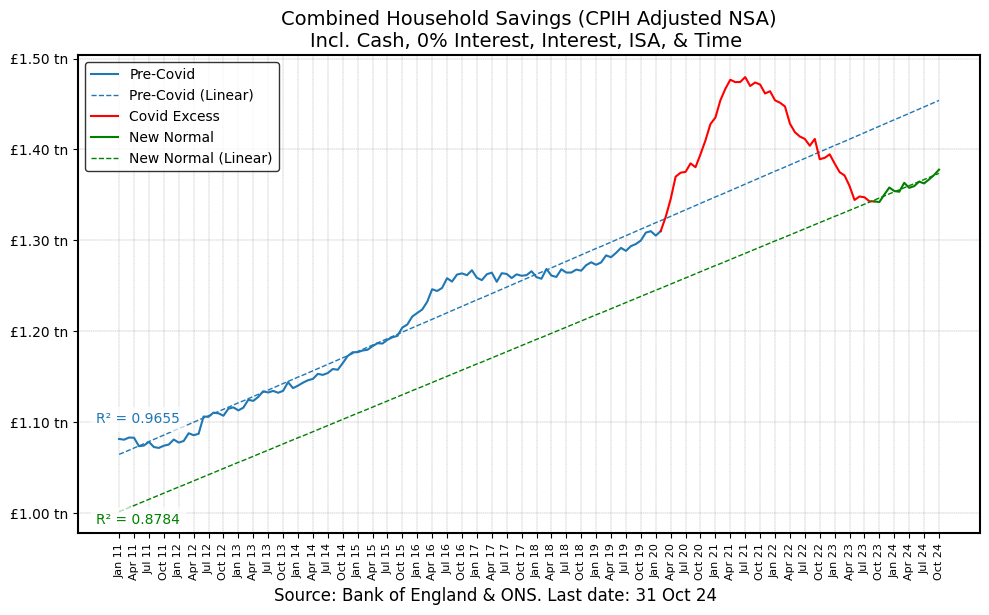

In [29]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.set_facecolor("white")

# Split the data based on the date
df_precovid = df_rsav[df_rsav["Date"] <= end_date]
df_covid = df_rsav[df_rsav["Date"] >= end_date]
df_new = df_covid[df_covid["Date"] >= new_date]
df_covid = df_covid[df_covid["Date"] <= new_date]

# Pre-covid
(line1,) = ax.plot(
    df_precovid["Month_Year"], df_precovid["Real_Total"], label="Pre-Covid"
)
color = line1.get_color()

ax.plot(
    df_rsav["Month_Year"],
    df_rsav["pre-covid-real"],
    label="Pre-Covid (Linear)",
    color=color,
    linestyle="--",
    linewidth=1,
)

# covid excess
ax.plot(
    df_covid["Month_Year"], df_covid["Real_Total"], color="red", label="Covid Excess"
)

# new normal
ax.plot(df_new["Month_Year"], df_new["Real_Total"], color="green", label="New Normal")

ax.plot(
    df_rsav["Month_Year"],
    df_rsav["new-real"],
    label="New Normal (Linear)",
    color="green",
    linestyle="--",
    linewidth=1,
)

ax.set_title(
    "Combined Household Savings (CPIH Adjusted NSA)"
    "\nIncl. Cash, 0% Interest, Interest, ISA, & Time ",
    fontsize=14,
)

formatter = FuncFormatter(pound_formatter)
plt.gca().yaxis.set_major_formatter(formatter)
ax.grid(True, color="grey", linestyle="--", linewidth=0.25)

xticks = df_rsav["Month_Year"][::3]  # every nth date
plt.xticks(xticks, rotation=90)
plt.tick_params(axis="x", labelsize=8)

# Set the spines (borders) to black
for spine in ax.spines.values():
    spine.set_edgecolor("black")
    spine.set_linewidth(1.5)

fig.text(
    0.5,
    -0.01,
    f"Source: Bank of England & ONS. Last date: {last_date}",
    ha="center",
    fontsize=12,
    color="black",
)

# Add Pre-covid R-squared as a note in the bottom-left corner
plt.text(
    0.02,
    0.23,  # Position: from the bottom-left
    f"R² = {precovid_r_squared:.4f}",
    transform=plt.gca().transAxes,  # (0,0 is bottom-left)
    fontsize=10,
    color=color,
    bbox=dict(facecolor="white", alpha=0.7, edgecolor="none"),
)
# Add New normal R-squared as a note in the bottom-left corner
plt.text(
    0.02,
    0.02,  # Position: from the bottom-left
    f"R² = {new_r_squared:.4f}",
    transform=plt.gca().transAxes,  # (0,0 is bottom-left)
    fontsize=10,
    color="green",
    bbox=dict(facecolor="white", alpha=0.7, edgecolor="none"),
)
plt.legend(facecolor="white", edgecolor="black", fontsize=10)
plt.tight_layout()

filename = os.path.join(PLOT_DIR, "savings_real.png")
plt.savefig(filename, dpi=300, bbox_inches="tight")

### No statistically significant difference in CPIH adjusted savings growth before and after

In [30]:
# Combine pre-COVID and New Normal data
df_new["Period"] = "New Normal"
df_combined = pd.concat([df_precovid, df_new])

# Encode the period as a binary variable
df_combined["Period_Binary"] = (df_combined["Period"] == "New Normal").astype(int)

# Define the independent variable (i.e., Date) and dependent variable
X = sm.add_constant(
    pd.DataFrame(
        {
            # Numeric representation of dates
            "Time": df_combined["Date"].factorize()[0],
            "Period_Binary": df_combined["Period_Binary"],
            "Interaction": df_combined["Date"].factorize()[0]
            * df_combined["Period_Binary"],
        }
    )
)
y = df_combined["Real_Total"]

model = sm.OLS(y, X).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:             Real_Total   R-squared:                       0.977
Model:                            OLS   Adj. R-squared:                  0.977
Method:                 Least Squares   F-statistic:                     1728.
Date:                Fri, 20 Dec 2024   Prob (F-statistic):           1.65e-98
Time:                        21:32:07   Log-Likelihood:                -3067.3
No. Observations:                 124   AIC:                             6143.
Df Residuals:                     120   BIC:                             6154.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const          1.065e+12   2.58e+09    413.098

## Credit Card Debt

In [31]:
df_credit = get_boe_data("credit", "LPMVZRE", "01/Jan/2015")
df_credit.columns = ["Date", "Total"]
df_credit["Total"] = df_credit["Total"] * 1000000
df_credit = df_credit.sort_values(by="Date")
df_credit["Month_Year"] = df_credit["Date"].dt.strftime("%b %y")
last_date = df_credit["Date"].max().strftime("%d %b %y")

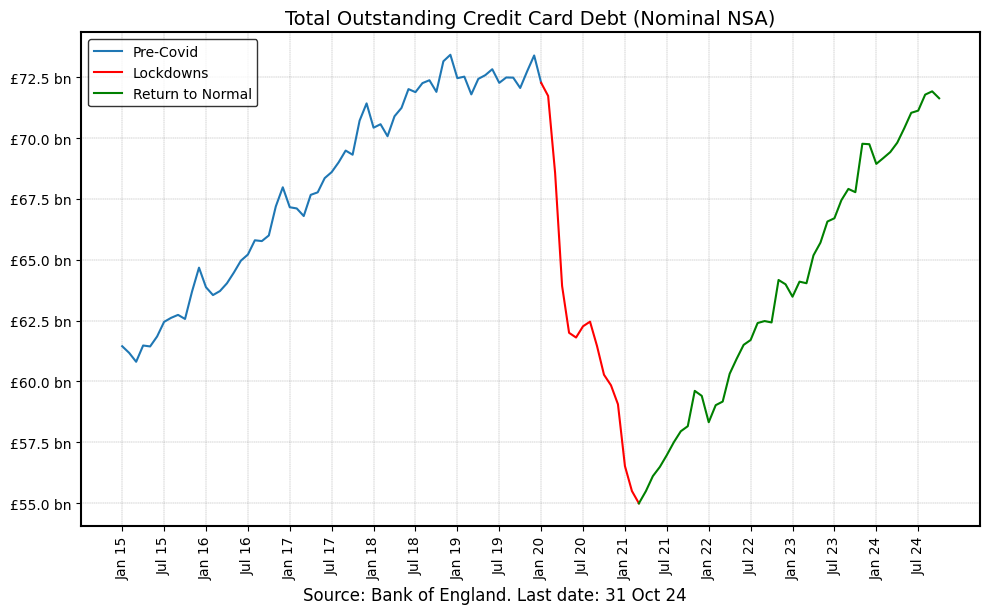

In [32]:
# Split the data based on the date
end_date = "2020-01-31"  # start of lockdowns
new_date = "2021-03-31"  # end of lockdowns
df_precovid = df_credit[df_credit["Date"] <= end_date]
df_covid = df_credit[df_credit["Date"] >= end_date]
df_new = df_covid[df_covid["Date"] >= new_date]
df_covid = df_covid[df_covid["Date"] <= new_date]

fig, ax = plt.subplots(figsize=(10, 6))

ax.set_facecolor("white")

# Pre-covid
(line1,) = ax.plot(df_precovid["Month_Year"], df_precovid["Total"], label="Pre-Covid")
color = line1.get_color()

# lockdowns
ax.plot(df_covid["Month_Year"], df_covid["Total"], color="red", label="Lockdowns")

# return to normal
ax.plot(df_new["Month_Year"], df_new["Total"], color="green", label="Return to Normal")

ax.set_title("Total Outstanding Credit Card Debt (Nominal NSA)", fontsize=14)

formatter = FuncFormatter(pound_formatter)
plt.gca().yaxis.set_major_formatter(formatter)
ax.grid(True, color="grey", linestyle="--", linewidth=0.25)

xticks = df_credit["Month_Year"][::6]  # every nth date
plt.xticks(xticks, rotation=90)

for spine in ax.spines.values():
    spine.set_edgecolor("black")
    spine.set_linewidth(1.5)

fig.text(
    0.5,
    -0.01,
    f"Source: Bank of England. Last date: {last_date}",
    ha="center",
    fontsize=12,
    color="black",
)

plt.legend(facecolor="white", edgecolor="black", fontsize=10)
plt.tight_layout()

filename = os.path.join(PLOT_DIR, "credit.png")
plt.savefig(filename, dpi=300, bbox_inches="tight")